Lecture: AI I - Advanced 

Previous:
[**Chapter 2.1: Regularization**](../01_regularization.ipynb)

---

# Exercise 2.1: Regularization

> Hint: When doing the exercises put your solution in the designated "Solution" section:
> ```python
> # Solution (put your code here)
> ```

## Task 1: Diabetes Regression with Multi-Layer Perceptron with Regularization

The diabetes dataset contains 442 samples with 10 baseline variables (age, sex, BMI, blood pressure, and 6 blood serum measurements). The target is a quantitative measure of disease progression one year after baseline.

**Tasks**
- Data Exploration & Understanding
- Data preparation
- Build Model a Multi-Layer Perceptron for regression and add regularization
- Train the model 
- Evaluate the model performance using appropriate regression metrics (e.g. MSE, MAE) and Tensorboard

In [2]:
# prerequisites (don't edit this block)
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
x = diabetes.data
y = diabetes.target

Samples - Train: 265, Val: 88, Test: 89
Starte Training mit Regularisierung...
Epoch  10 | Train Loss: 15179.6526 | Val Loss: 15376.1317
Epoch  20 | Train Loss: 4153.8370 | Val Loss: 3553.0693
Epoch  30 | Train Loss: 3937.1322 | Val Loss: 2624.9147
Epoch  40 | Train Loss: 3678.2034 | Val Loss: 2991.0051
Epoch  50 | Train Loss: 3203.4304 | Val Loss: 2883.9049
Early stopping at epoch 50

Final Test MSE: 2675.9221


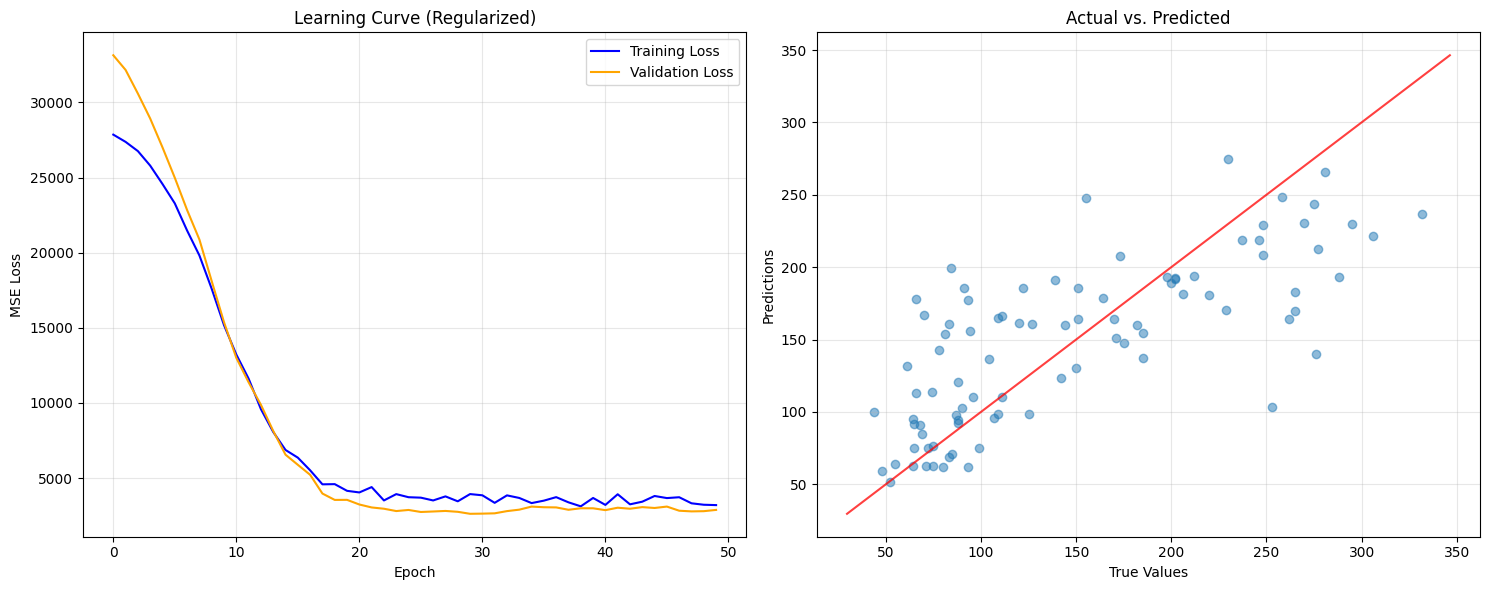

In [54]:
# Solution (put your code here)
# Solution (put your code here)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

X_tensor = torch.tensor(x, dtype=torch.float32)
Y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

mean = X_tensor.mean(dim=0, keepdim=True)
std = X_tensor.std(dim=0, keepdim=True)
X_norm = (X_tensor - mean) / (std + 1e-7)

n = len(X_norm)
ids = torch.randperm(n)

# Split 60% train, 20% validation, 20% test
train_ids = ids[:int(n * 0.6)]
val_ids = ids[int(n * 0.6):int(n * 0.8)]
test_ids = ids[int(n * 0.8):]

train_dataset = TensorDataset(X_norm[train_ids], Y_tensor[train_ids])
val_dataset = TensorDataset(X_norm[val_ids], Y_tensor[val_ids])
test_dataset = TensorDataset(X_norm[test_ids], Y_tensor[test_ids])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Samples - Train: {len(train_ids)}, Val: {len(val_ids)}, Test: {len(test_ids)}")

class RegularizedDiabetesMLP(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.3): # Dropout Rate Parameter
        super().__init__()
        
        # Layer 1
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)        # Batch Norm für Layer 1
        self.dropout1 = nn.Dropout(dropout_rate) # Dropout für Layer 1
        
        # Layer 2
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)        # Batch Norm für Layer 2
        self.dropout2 = nn.Dropout(dropout_rate) # Dropout für Layer 2
        
        # Output Layer
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        # Übliche Reihenfolge: Linear -> BatchNorm -> Activation -> Dropout
        
        x = self.fc1(x)
        x = self.bn1(x)      # 1. Batch Norm
        x = F.relu(x)        # 2. Activation
        x = self.dropout1(x) # 3. Dropout
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)      # Output ohne Dropout/BN
        return x

# Modell initialisieren
model = RegularizedDiabetesMLP(input_dim=10, dropout_rate=0.4) # Etwas aggressiveres Dropout (40%)

# --- ÄNDERUNG 2: Optimizer mit Weight Decay (L2 Regularization) ---
# weight_decay=0.01 bestraft große Gewichte
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01) 

criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

# Listen für Plotting initialisieren (WICHTIG: VOR dem Loop)
train_losses = []
val_losses = []

# Training Loop
num_epochs = 200
best_val_loss = float('inf')
patience_counter = 0
early_stopping = 20

print("Starte Training mit Regularisierung...")

for epoch in range(num_epochs):
    # Train
    model.train() # Wichtig: Aktiviert Dropout und BatchNorm Verhalten
    total_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_X.size(0)
    train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(train_loss) # Speichern für Plot

    # Validate
    model.eval() # Wichtig: Deaktiviert Dropout, nutzt fixes BatchNorm
    total_val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            total_val_loss += loss.item() * batch_X.size(0)
    val_loss = total_val_loss / len(val_loader.dataset)
    val_losses.append(val_loss) # Speichern für Plot
    
    # Scheduler
    scheduler.step(val_loss)
    
    # Checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'diabetes_regularized_best.pth')
    else:
        patience_counter += 1
        
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        
    if patience_counter >= early_stopping:
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Visualisierung ---

# Bestes Modell laden
model.load_state_dict(torch.load('diabetes_regularized_best.pth'))
model.eval()

# Test Predictions sammeln
y_true = []
y_pred_vals = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        preds = model(batch_X)
        y_true.extend(batch_y.numpy())
        y_pred_vals.extend(preds.numpy())
y_true = np.array(y_true).flatten()
y_pred_vals = np.array(y_pred_vals).flatten()

# Metriken berechnen
final_mse = ((y_true - y_pred_vals)**2).mean()
print(f"\nFinal Test MSE: {final_mse:.4f}")

# Plots erstellen
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot A: Learning Curve
# Hier solltest du sehen, dass die Lücke zwischen Blau (Train) und Orange (Val) kleiner ist als vorher
axs[0].plot(train_losses, label='Training Loss', color='blue')
axs[0].plot(val_losses, label='Validation Loss', color='orange')
axs[0].set_title('Learning Curve (Regularized)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('MSE Loss')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Plot B: Actual vs Predicted
axs[1].scatter(y_true, y_pred_vals, alpha=0.5)
lims = [np.min([axs[1].get_xlim(), axs[1].get_ylim()]), np.max([axs[1].get_xlim(), axs[1].get_ylim()])]
axs[1].plot(lims, lims, 'r-', alpha=0.75)
axs[1].set_title('Actual vs. Predicted')
axs[1].set_xlabel('True Values')
axs[1].set_ylabel('Predictions')
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Test case (don't edit this block)
assert True

---

Lecture: AI I - Advanced 

Next: [**Chapter 2.2: Optimization**](../02_optimization.ipynb)